In [ ]:
jupyter lab --port=44000 --ip=$HOSTNAME --no-browser

In [1]:
%load_ext autoreload
%autoreload 2
%env MUJOCO_GL=egl
!echo $CUDA_VISIBLE_DEVICES
!echo $HOSTNAME
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media

np.set_printoptions(precision=3, suppress=True, linewidth=100)

env: MUJOCO_GL=egl
0
n-62-12-19


## 采样抛物线数据

""

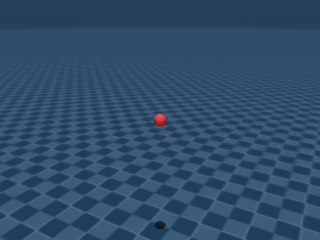

In [2]:
xml = """
<mujoco model="parabolic_target">
  <compiler angle="radian" autolimits="true"/>
  <option integrator="implicit" impratio="10"/>
  <statistic extent="1.5" center="-0.9 0 1"/>
  <visual>
    <headlight diffuse="0.6 0.6 0.6"  ambient="0.3 0.3 0.3" specular="0 0 0"/>
    <rgba haze="0.15 0.25 0.35 1"/>
    <global azimuth="120" elevation="-20"/>
  </visual>
  <default>
    <default class="target">
      <geom rgba=".5 .5 .5 .4"/>
    </default>
  </default>
  <asset>
    <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512"
        height="3072"/>
    <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4"
        rgb2="0.1 0.2 0.3" markrgb="0.8 0.8 0.8" width="300" height="300"/>
    <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5"
        reflectance="0.2"/>
  </asset>
  <worldbody>
    <camera name="target" pos="-2.175 -1.007 1.015" xyaxes="0.377 -0.926 0.000 0.208 0.084 0.975"/>
    <light pos="0 0 1.5" dir="0 0 -1" directional="true"/>
    <geom name="floor" size="0 0 0.05" type="plane" material="groundplane"/>
    <body name="reference" pos="-0.9 0 1.0">
      <geom type="sphere" size=".05 .05 .05" rgba="1 0 0 .5"/>
      <site type="sphere" size=".05 .05 .05" name="reference_site"/>
    </body>
    <body name="target" pos="-0.9 0 1.0">
      <geom type="sphere" size=".05 .05 .05" class="target"/>
      <freejoint name="target"/>
      <site type="sphere" size=".05 .05 .05" name="target_site"/>
    </body>
  </worldbody>
  <sensor>
    <touch name="hit" site="target_site"/>
  </sensor>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera="closeup")
media.show_image(renderer.render())

In [4]:
def init_controller(model, data, 
                    theta=np.pi/8, v=5):
    jID = f'target'
    x0, y0, z0 = -0.9, 0, 1.0
    vx, vy, vz = 0.0, v*np.cos(theta), v*np.sin(theta)
    data.joint(jID).qpos = np.array([x0, y0, z0, 1, 0, 0, 0])
    data.joint(jID).qvel = np.array([vx, vy, vz, 0, 0.1, 0.1])

In [12]:
duration = 1    # (seconds)
framerate = 60  # (Hz)
frames = []
distances = []
heights = []
y_vels = []
z_vels = []
timevals = []
forces = []
model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
init_controller(model, data, theta=np.pi/6, v=8)
while data.time < duration:
    mujoco.mj_step(model, data)
    distances.append(data.joint("target").qpos[1])
    heights.append(data.joint("target").qpos[2])
    y_vels.append(data.joint("target").qvel[1])
    z_vels.append(data.joint("target").qvel[2])
    forces.append(data.sensordata[0])
    timevals.append(data.time)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, "closeup")
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

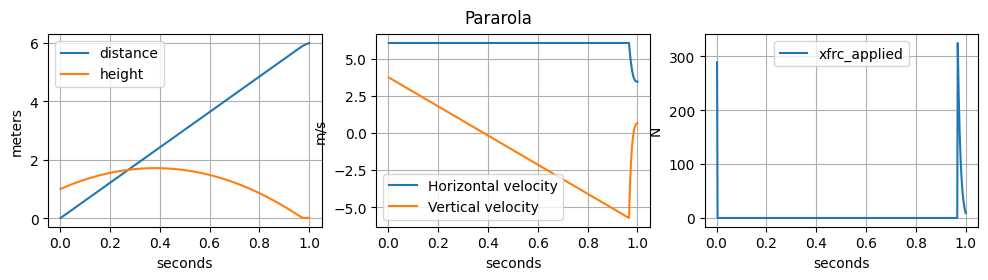

In [16]:

_, ax = plt.subplots(1, 3, figsize=(12,2.5))
plt.suptitle('Pararola')

ax[0].plot(timevals, distances, label='distance')
ax[0].plot(timevals, heights, label='height')
ax[0].set_ylabel('meters')
ax[0].set_xlabel('seconds')
ax[0].legend()
ax[0].grid()

ax[1].plot(timevals, y_vels, label='Horizontal velocity')
ax[1].plot(timevals, z_vels, label='Vertical velocity')
ax[1].set_ylabel('m/s')
ax[1].set_xlabel('seconds')
ax[1].legend()
ax[1].grid()

ax[2].plot(timevals, forces, label='xfrc_applied')
ax[2].set_ylabel('N')
ax[2].set_xlabel('seconds')
ax[2].legend()
ax[2].grid()

In [14]:
forces[:5], forces[-5:]

([288.8916697199035, 0.0, 0.0, 0.0, 0.0],
 [27.594293760298047,
  21.436369226395122,
  16.397383178777964,
  12.295767201968935,
  8.978162286132049])

In [93]:
xs = [-0.9,]*len(timevals)
ys = [-i for i in distances]
zs = heights

mocap_data = np.vstack([timevals,
                        [-0.9,]*len(timevals),
                        [-i for i in distances],
                        heights,
                        [0,]*len(timevals),
                        y_vels,
                        [-i for i in z_vels]]).T[::-1, :]

In [17]:
mocap_data.shape, mocap_data[-1], mocap_data[0]

((500, 7),
 array([ 0.002, -0.9  , -0.012,  1.007,  0.   ,  6.065, -3.74 ]),
 array([ 1.   , -0.9  , -5.997,  0.022,  0.   ,  3.465, -0.678]))

In [5]:
data.qpos[:2] = [0, 1]
data.qpos[:2]

array([0., 1.])

In [98]:
# save mocap data as npy file
np.save('env/xml/target_mocap.npy', mocap_data)

In [95]:
def init_controller(model, data, mocap_data=mocap_data):
    jID = f'target'
    random_idx = np.random.randint(0, len(mocap_data)-150)
    time = mocap_data[random_idx][0]
    qpos = mocap_data[random_idx][1:4]
    qvel = mocap_data[random_idx][4:]
    data.joint(jID).qpos = np.array([*qpos, 1, 0, 0, 0])
    data.joint(jID).qvel = np.array([*qvel, 0, 0.1, 0.1])
    print(f"设置初始位置为:\ntime={time}\nqpos={qpos}\nqvel={qvel}")

In [96]:
duration = 1    # (seconds)
framerate = 60  # (Hz)
frames = []
model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
init_controller(model, data)
while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, "closeup")
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

设置初始位置为:
time=0.7940000000000006
qpos=[-0.9   -4.816  0.885]
qvel=[0.    6.065 4.029]


In [9]:
mocap_data = np.load('env/xml/target_mocap.npy')

In [16]:
idx = np.where(mocap_data[:, 2] > -3)[0][0]
time_lapse = mocap_data[idx][0]
time_lapse

0.4940000000000004